<a href="https://colab.research.google.com/github/AlexeyKarz/food-models/blob/main/binary_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Food Vision With Keras and TensorFlow

During this project I will create a **CNN** (Convolutional Neural Network) using **Keras Sequential API**. I will work with a dataset of food images (hamburgers and pizzas) which is a subset of the food101 dataset, which contains 101 food categories with 101'000 images. The original source paper and data is [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). The data was extracted using functions from this [file](https://github.com/AlexeyKarz/food-models/blob/main/extra/data_extracting.ipynb). I will also use some functions from this [file](https://github.com/AlexeyKarz/food-models/blob/main/extra/food_helper_functions.py) for different perposes, the original [code](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) of some of these functions was made by ZTM.

The project was made following instructions of ZTM course. The materials could be found here: [GitHub link](https://github.com/mrdbourke/tensorflow-deep-learning/tree/main)

# Setting the WorkSpace

In [ ]:
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.14.0


In [ ]:
#check available devices
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


If the result is `['/device:CPU:0']` then GPU is available for training the models

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # get access for google drive

Mounted at /content/drive


I will import some the module with heler functions, that might be useful for evaluating the model and making predictions.

In [ ]:
!wget https://raw.githubusercontent.com/AlexeyKarz/food-models/main/extra/food_helper_functions.py
import food_helper_functions

--2023-11-12 10:19:40--  https://raw.githubusercontent.com/AlexeyKarz/food-models/main/food_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8540 (8.3K) [text/plain]
Saving to: ‘food_helper_functions.py.1’

food_helper_functio 100%[===================>]   8.34K  --.-KB/s    in 0s      

2023-11-12 10:19:40 (64.1 MB/s) - ‘food_helper_functions.py.1’ saved [8540/8540]



In [ ]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-11-12 10:19:40.933386


# Getting, Inspecting and Visualising the data

For this project I will use a subsets of the original food101 dataset - Hamburger and Pizza dataset.

In [ ]:
folder_path = '/content/drive/MyDrive/Projects/food101/hamburger_and_pizza'

In [ ]:
!ls /content/drive/MyDrive/Projects/food101/hamburger_and_pizza

test  train


In [ ]:
!ls /content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train

hamburger  pizza


Walking through the directory and listing the number of files

In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/hamburger'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/pizza'.


Now I will create a function that visualizes three random images of a selected class

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_three_images(target_dir, target_class):
    """
    Randomly selects and displays 3 random images
    from `target_class` folder in `target_dir` folder.
    """
    target_path = target_dir + target_class
    file_names = os.listdir(target_path)
    target_images = random.sample(file_names, 3)

    plt.figure(figsize=(10, 3))
    for i, img in enumerate(target_images):
        img_path = target_path + "/" + img
        plt.subplot(1, 3, i+1)
        plt.imshow(mpimg.imread(img_path))
        plt.title(target_class)
        plt.axis("off")

I will include the function above into food_helper_functions to use in the next projects

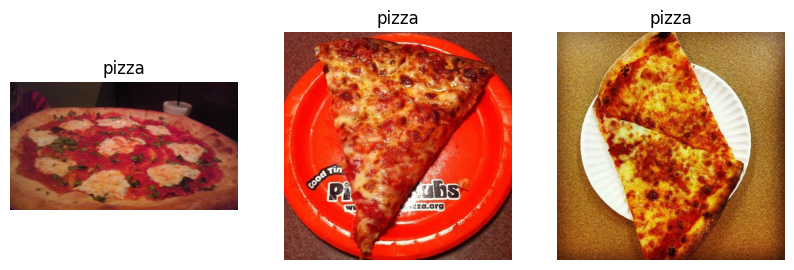

In [ ]:
view_three_images(target_dir="/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/",
                  target_class="pizza")

# Building the model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

Preprocessing of the data and creating Mini Batches

In [ ]:
tf.random.set_seed(42)
BATCH_SIZE = 32
TARGET_SIZEE = (224, 224)

# preprocessing the data (including normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_path = "/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/"
test_path = "/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/test/"

train_data = train_datagen.flow_from_directory(train_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=TARGET_SIZEE,
                                               class_mode='binary',
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_path,
                                               batch_size=BATCH_SIZE,
                                               target_size=TARGET_SIZEE,
                                               class_mode='binary',
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Building, compiling and training the model

In [ ]:
model_binary_1 = tf.keras.models.Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=TARGET_SIZEE + (3, )),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(pool_size=2, padding='valid'),
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_binary_1.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [ ]:
history_1 = model_binary_1.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=len(valid_data)*0.25) # to speed up the process

Epoch 1/5
47/47 [==============================] - 477s 10s/step - loss: 0.6665 - accuracy: 0.5773 - val_loss: 0.5945 - val_accuracy: 0.6484
Epoch 2/5
47/47 [==============================] - 60s 1s/step - loss: 0.5551 - accuracy: 0.7027 - val_loss: 0.5189 - val_accuracy: 0.7734
Epoch 3/5
47/47 [==============================] - 53s 1s/step - loss: 0.4707 - accuracy: 0.7807 - val_loss: 0.6170 - val_accuracy: 0.6562
Epoch 4/5
47/47 [==============================] - 34s 733ms/step - loss: 0.4198 - accuracy: 0.8033 - val_loss: 0.4052 - val_accuracy: 0.7812
Epoch 5/5
47/47 [==============================] - 30s 657ms/step - loss: 0.3369 - accuracy: 0.8553 - val_loss: 0.4456 - val_accuracy: 0.8047


# Evaluating the model

In [ ]:
model_binary_1.evaluate(valid_data)

16/16 [==============================] - 35s 2s/step - loss: 0.4984 - accuracy: 0.7480


[0.4983711838722229, 0.7480000257492065]

In [ ]:
model_binary_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

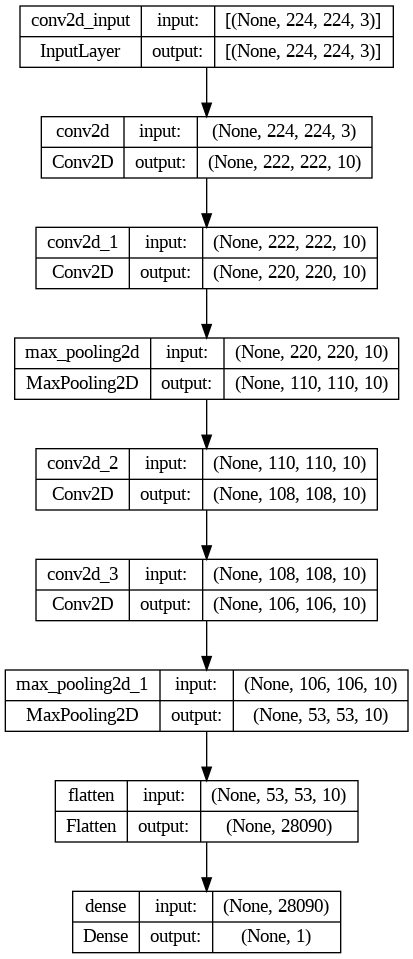

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_binary_1, show_shapes=True, show_layer_names=True)

Plotting the training curves

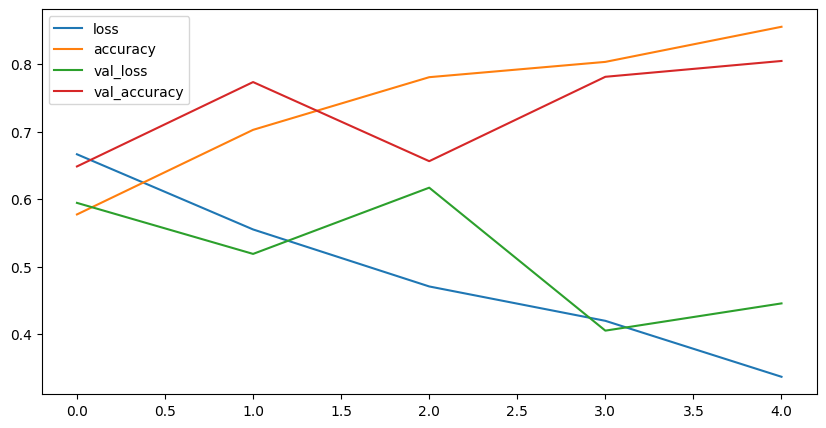

In [ ]:
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 5));

# Fine-tuning the model

Looks like the model is overfitting.To solve this problem:
1. First I will try to add the data augmenting layer to the model.
2. Second I will try to add dropout layers to the model

In [ ]:
from tensorflow.keras import layers
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name = 'data_augmentation')

Now I will rebuild the model. I will also use GlobalMaxPool2D instead of Flatten layer, because Dense layer needs a fixed shape for the last dimension, which could not be provided using flattened batches if I use augmented data (RandomWidth and RandomHeight lead to `None` dimensions).

In [ ]:
from tensorflow.keras.layers import Dropout, GlobalMaxPool2D

In [ ]:
model_binary_2 = tf.keras.models.Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=TARGET_SIZEE + (3, )),
    data_augmentation,
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(pool_size=2, padding='valid'),
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    MaxPool2D(2),
    GlobalMaxPool2D(),
    Dense(1, activation='sigmoid')
])

model_binary_2.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [ ]:
history_2 = model_binary_2.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=len(valid_data)*0.25) # to speed up the process


Epoch 1/5
47/47 [==============================] - 23s 359ms/step - loss: 0.6940 - accuracy: 0.4907 - val_loss: 0.6929 - val_accuracy: 0.5156
Epoch 2/5
47/47 [==============================] - 16s 330ms/step - loss: 0.6930 - accuracy: 0.5047 - val_loss: 0.6947 - val_accuracy: 0.4844
Epoch 3/5
47/47 [==============================] - 20s 411ms/step - loss: 0.6911 - accuracy: 0.5193 - val_loss: 0.6841 - val_accuracy: 0.6016
Epoch 4/5
47/47 [==============================] - 17s 353ms/step - loss: 0.6875 - accuracy: 0.5753 - val_loss: 0.6834 - val_accuracy: 0.5391
Epoch 5/5
47/47 [==============================] - 16s 342ms/step - loss: 0.6854 - accuracy: 0.5460 - val_loss: 0.6821 - val_accuracy: 0.5312


In [ ]:
model_binary_2.evaluate(valid_data)

16/16 [==============================] - 3s 154ms/step - loss: 0.6888 - accuracy: 0.5100


[0.6888154745101929, 0.5099999904632568]

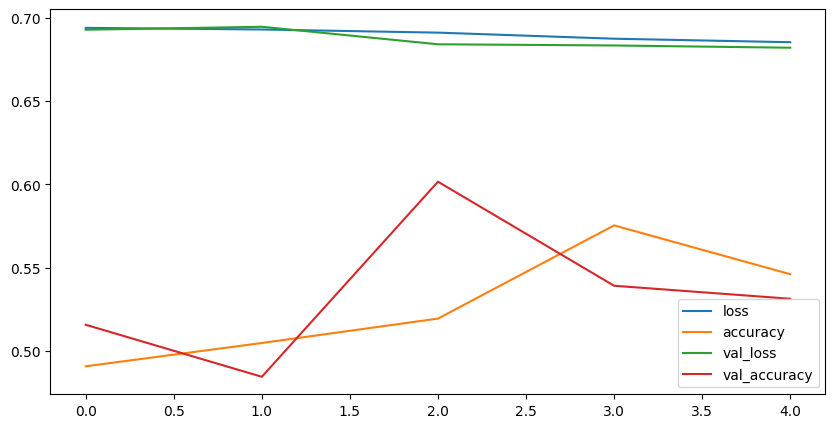

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(10, 5));

Looks like model works worse without Flatten layer

Now I will add only Dropout layers, keeping the Flatten layer

In [ ]:
model_binary_3 = tf.keras.models.Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           activation='relu',
           input_shape=TARGET_SIZEE + (3, )),
    Conv2D(10, 3, activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size=2, padding='valid'),
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_binary_3.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

history_3 = model_binary_3.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data),
                               validation_data=valid_data,
                               validation_steps=len(valid_data)*0.25) # to speed up the process


Epoch 1/5
47/47 [==============================] - 13s 217ms/step - loss: 0.6874 - accuracy: 0.5600 - val_loss: 0.6414 - val_accuracy: 0.6250
Epoch 2/5
47/47 [==============================] - 8s 181ms/step - loss: 0.6063 - accuracy: 0.6793 - val_loss: 0.5631 - val_accuracy: 0.7500
Epoch 3/5
47/47 [==============================] - 10s 207ms/step - loss: 0.5515 - accuracy: 0.7220 - val_loss: 0.5151 - val_accuracy: 0.7266
Epoch 4/5
47/47 [==============================] - 9s 186ms/step - loss: 0.4985 - accuracy: 0.7520 - val_loss: 0.5110 - val_accuracy: 0.7422
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.4455 - accuracy: 0.7993 - val_loss: 0.4860 - val_accuracy: 0.7422


In [ ]:
model_binary_3.evaluate(valid_data)

16/16 [==============================] - 2s 153ms/step - loss: 0.4816 - accuracy: 0.7460


[0.48158442974090576, 0.7459999918937683]

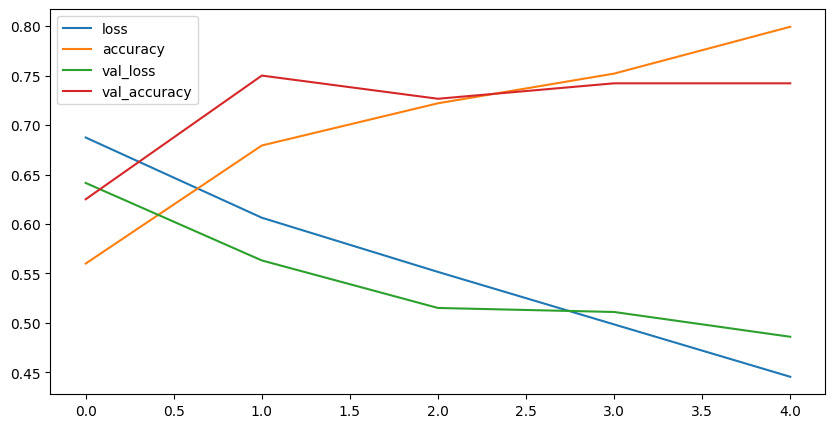

In [ ]:
pd.DataFrame(history_3.history).plot(figsize=(10, 5));

It seems that Flatten layer with Droupout layers lead to a better performance. So I will try to use them and also use data augmentation. For this I will create augmented data batches to train the model on them.

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)


train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 1500 images belonging to 2 classes.


Now I will build a model with the same structure as model 3 which would be trained on the augmented data

In [ ]:
model_binary_4 = tf.keras.models.Sequential([
    Conv2D(10, 3, activation = 'relu', input_shape=TARGET_SIZEE + (3, )),
    Conv2D(10, 3, activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(2),
    Conv2D(10, 3, activation = 'relu'),
    Conv2D(10, 3, activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_binary_4.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

history_4 = model_binary_4.fit(train_data,
                               epochs=5,
                               steps_per_epoch=len(train_data_augmented),
                               validation_data=valid_data,
                               validation_steps=len(valid_data)*0.25) # to speed up the process


Epoch 1/5
47/47 [==============================] - 12s 189ms/step - loss: 0.6510 - accuracy: 0.6247 - val_loss: 0.6142 - val_accuracy: 0.6797
Epoch 2/5
47/47 [==============================] - 10s 205ms/step - loss: 0.5289 - accuracy: 0.7367 - val_loss: 0.4912 - val_accuracy: 0.7500
Epoch 3/5
47/47 [==============================] - 8s 176ms/step - loss: 0.4541 - accuracy: 0.7927 - val_loss: 0.4532 - val_accuracy: 0.7812
Epoch 4/5
47/47 [==============================] - 10s 205ms/step - loss: 0.4207 - accuracy: 0.8113 - val_loss: 0.4585 - val_accuracy: 0.7734
Epoch 5/5
47/47 [==============================] - 8s 168ms/step - loss: 0.3844 - accuracy: 0.8313 - val_loss: 0.3854 - val_accuracy: 0.8516


In [ ]:
model_binary_4.evaluate(valid_data)

16/16 [==============================] - 3s 170ms/step - loss: 0.4437 - accuracy: 0.8100


[0.44367897510528564, 0.8100000023841858]

## Evaluating the final model

It doesn't look like that it led to a significantly better or worse perfomance, but the last model has the least tendency to overfitting

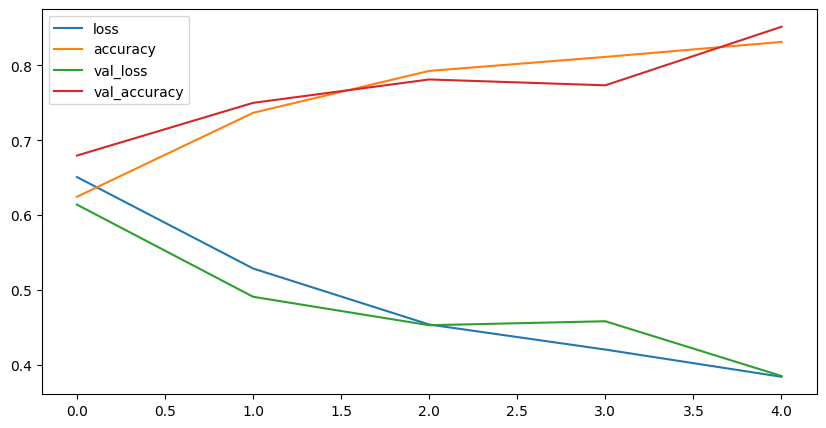

In [ ]:
pd.DataFrame(history_4.history).plot(figsize=(10, 5));

In [ ]:
model_binary_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_13 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 dropout_2 (Dropout)         (None, 220, 220, 10)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 10)      910       
                                                      

## Building confusion matrix

To evaluate the final model I will build confusion matrix using pre-downloaded function.

In [ ]:
y_true = []  # Initialize an empty list to collect true labels

for images in range(len(valid_data)):
    images, labels = valid_data.next()  # Get the labels for the current batch
    y_true.extend(labels)  # Extend the list with the batch labels


In [ ]:
y_true[:10], len(y_true)

([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0], 500)

In [ ]:
y_pred = model_binary_4.predict(valid_data, steps=len(valid_data), verbose=1)
y_pred[:10], len(y_pred)

16/16 [==============================] - 3s 152ms/step


(array([[0.8468045 ],
        [0.05058029],
        [0.7089063 ],
        [0.2515149 ],
        [0.6420159 ],
        [0.59528834],
        [0.702572  ],
        [0.75749385],
        [0.43909234],
        [0.82264304]], dtype=float32),
 500)

Let's convert probabilities to predicted labels

In [ ]:
import numpy as np
y_pred = np.round(y_pred)
 # this will create an array of lists
y_pred = np.squeeze(y_pred) # convert to the same form as y_true
y_pred[:10], len(y_pred)

(array([1., 0., 1., 0., 1., 1., 1., 1., 0., 1.], dtype=float32), 500)

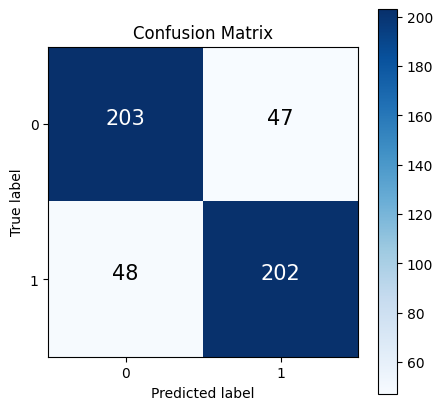

In [ ]:
food_helper_functions.make_confusion_matrix(y_true, y_pred, figsize=(5,5))

Confusion matrix shows that model predicts almost equally both of the classes. To be precise, I will first extract the class names, so I could know what is 0 and 1

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/") # turning the training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['hamburger' 'pizza']


I will also find models other mterics (precision, recall, f1) using pre-downloaded helper function. First I have to get y_true and y_pred values

In [ ]:
food_helper_functions.calculate_results_binary(y_true, y_pred)

{'accuracy': 81.0,
 'precision': 0.8100049600793613,
 'recall': 0.81,
 'f1': 0.8099992399969599}

The model's perfomance is not bad but is still not very effecient. Probable reasons are the similarity of images (lots of ingridients, some of them are the same) and poor model's architecture. The possible ways to encance the model in future are to try transfer learning for binary classification or to find better data.

# Making a prediction on custon data

For this purpose I will use a random image I found in google.

--2023-11-12 10:35:19--  https://assets.biggreenegg.eu/app/uploads/2019/03/28145521/topimage-classic-hamburger-2019m04-800x534.jpg
Resolving assets.biggreenegg.eu (assets.biggreenegg.eu)... 18.239.94.98, 18.239.94.37, 18.239.94.17, ...
Connecting to assets.biggreenegg.eu (assets.biggreenegg.eu)|18.239.94.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379428 (371K) [image/jpeg]
Saving to: ‘topimage-classic-hamburger-2019m04-800x534.jpg.2’

topimage-classic-ha 100%[===================>] 370.54K  --.-KB/s    in 0.02s   

2023-11-12 10:35:19 (21.0 MB/s) - ‘topimage-classic-hamburger-2019m04-800x534.jpg.2’ saved [379428/379428]



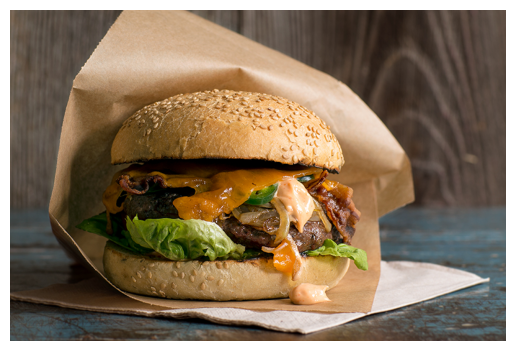

In [ ]:
!wget https://assets.biggreenegg.eu/app/uploads/2019/03/28145521/topimage-classic-hamburger-2019m04-800x534.jpg
hamburger = mpimg.imread("topimage-classic-hamburger-2019m04-800x534.jpg")
plt.imshow(hamburger)
plt.axis(False);

In [ ]:
hamburger.shape

(534, 800, 3)

Since the model takes images of shape (224, 224, 3), I have to reshape custom image. I will use the imported functions (for processing and making preiction) for this purpose.

In [ ]:
hamburger = food_helper_functions.load_and_process("topimage-classic-hamburger-2019m04-800x534.jpg")

In [ ]:
model_binary_4.predict(tf.expand_dims(hamburger, axis=0))

1/1 [==============================] - 0s 150ms/step


array([[0.15836002]], dtype=float32)

It is hard to understand the prediction, so I will create a function that makes a prediction and visualizes it. For this, I will first extract the class names.

In [ ]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/Projects/food101/hamburger_and_pizza/train/") # turning the training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['hamburger' 'pizza']


1/1 [==============================] - 0s 22ms/step


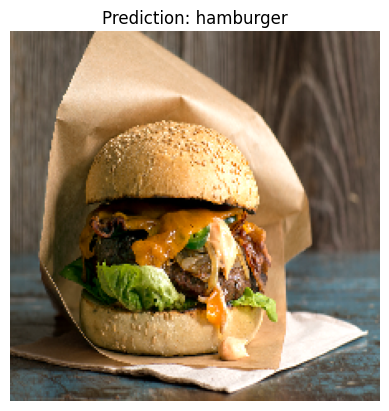

In [ ]:
food_helper_functions.pred_plot(model_binary_4, "topimage-classic-hamburger-2019m04-800x534.jpg", class_names)

The model predicted correctly on imported image

# Saving the model

In [ ]:
model_binary_4.save("saved_binary_model")

I will also load this model and evaluate it to compare to the unsaved model results to be sure that is was saved correctly

In [ ]:
loaded_model_4 = tf.keras.models.load_model('saved_binary_model')
loaded_model_4.evaluate(valid_data)

16/16 [==============================] - 3s 157ms/step - loss: 0.4437 - accuracy: 0.8100


[0.44367894530296326, 0.8100000023841858]

In [ ]:
model_binary_4.evaluate(valid_data)

16/16 [==============================] - 3s 193ms/step - loss: 0.4437 - accuracy: 0.8100


[0.44367894530296326, 0.8100000023841858]